# Esercizio 1: Classification Iris

dataset: https://archive.ics.uci.edu/ml/datasets/iris

In [2]:
from sklearn import tree 
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score 
import graphviz 
from imblearn.over_sampling import SMOTE
from collections import Counter
from itertools import repeat


##### load the dataset and split it in train and test set

In [3]:
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, random_state=1)

##### Initialize the model and fit with the training data

In [4]:
# the weights are the same for all the classes
clf = tree.DecisionTreeClassifier(criterion="entropy",random_state=300,min_samples_leaf=5,class_weight={0:1,1:1,2:1}) 
clf = clf.fit(X_train, y_train)

##### Predict the classes of the test set

In [5]:
predicted_y_test = clf.predict(X_test)

##### Printing information about the model

In [6]:
print(f"predicted classes:\n{predicted_y_test}\n")
print(f"real classes:\n{y_test}")
print(f"\ncorrectly classified examples: {sum(predicted_y_test == y_test)}")
print(f"number of errors: {sum(predicted_y_test != y_test)}")

predicted classes:
[0 1 1 0 2 1 2 0 0 2 1 0 2 1 1 0 1 1 0 0 1 1 2 0 2 1 0 0 1 2 1 2 1 2 2 0 1
 0 1 2 2 0 1 2 1]

real classes:
[0 1 1 0 2 1 2 0 0 2 1 0 2 1 1 0 1 1 0 0 1 1 1 0 2 1 0 0 1 2 1 2 1 2 2 0 1
 0 1 2 2 0 2 2 1]

correctly classified examples: 43
number of errors: 2


In [ ]:
for i in range(len(y_test)):
    print(f"class {iris.target_names[y_test[i]]} predicted as {iris.target_names[predicted_y_test[i]]}")
    for j in range(len(iris.feature_names)):
        print(f"{iris.feature_names[j]}: {X_test[i][j]}")
    print("\n")

##### Accuracy and F1 of the model 
- F1 = 2 * (precision * recall) / (precision + recall)

In [7]:
print(f"accuracy: {accuracy_score(y_test, predicted_y_test)}")
f1 = f1_score(y_test, predicted_y_test, average='macro') # macro means that the score is calculated for each class and then averaged
print(f"f1 score: {f1}")

accuracy: 0.9555555555555556
f1 score: 0.9558404558404558


##### Cross Validation

In [8]:
#cross validation
accuracy_scores = cross_val_score(clf, iris.data, iris.target, cv=5) # default score is the accuracy, 5-fold cross validation
print(f"cross validation scores: {accuracy_scores}")
f1_scores = cross_val_score(clf, iris.data, iris.target, cv=5, scoring='f1_macro') 
print(f"cross validation f1 scores: {f1_scores}")

cross validation scores: [0.96666667 1.         0.86666667 0.86666667 1.        ]
cross validation f1 scores: [0.96658312 1.         0.86111111 0.86666667 1.        ]


##### Visualize the Tree with Graphviz

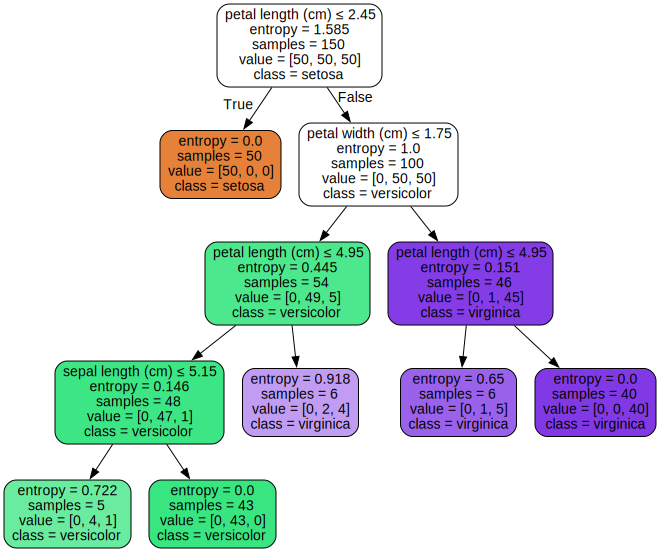

In [9]:
# initialize another classifier to visualize the graph on the total examples
clf_graph = tree.DecisionTreeClassifier(criterion="entropy",random_state=300,min_samples_leaf=5,class_weight={0:1,1:1,2:1})
clf_graph = clf_graph.fit(iris.data, iris.target)

dot_data = tree.export_graphviz(clf_graph, out_file=None, 
                                feature_names=iris.feature_names,
                                class_names=iris.target_names,
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph

- The maximum entropy is log2(3) = 1.585
- The minimum entropy is 0
- The class is chosen by the majority of the samples

### 1.a Oversampling (Artificial Inflation)

Applicate un sovracampionamento (artificial inflation) ad una classe nel training set con un determinato fattore: 10 (si pesi di più una delle classi tra virginica o versicolor che sono più difficili da discriminare). Si apprenda l'albero di decisione in queste condizioni.

In [10]:
def oversampling(X_train, y_train, oversampling_factor):
	X_train_augmented = []
	y_train_augmented = []
	for (x,y) in zip(X_train, y_train):
		if y == 2:
			X_train_augmented.extend(repeat(x, oversampling_factor))
			y_train_augmented.extend(repeat(y, oversampling_factor))
		else:
			X_train_augmented.append(x)
			y_train_augmented.append(y)
	return X_train_augmented, y_train_augmented

def compute_fp_tp_fn_tn(real_value, predicted_value, positive_class):
	# returns tuple (fp, tp, fn, tn)
	fp, tp, fn, tn = 0, 0, 0, 0
	for i in range(len(real_value)):
		if real_value[i] == positive_class and predicted_value[i] == positive_class:
			tp += 1
		elif real_value[i] != positive_class and predicted_value[i] == positive_class:
			fp += 1
		elif real_value[i] == positive_class and predicted_value[i] != positive_class:
			fn += 1
		elif real_value[i] != positive_class and predicted_value[i] != positive_class:
			tn += 1
	return fp, tp, fn, tn

In [21]:
OVERSAMPLING_FACTOR = 10

clf_oversampling = tree.DecisionTreeClassifier(criterion="entropy",random_state=300,min_samples_leaf=5,class_weight={0:1,1:1,2:1})

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, random_state=1)

X_train_oversample, y_train_oversample = oversampling(X_train, y_train, OVERSAMPLING_FACTOR)

clf_oversampling = clf_oversampling.fit(X_train_oversample, y_train_oversample)

predicted_y_test = clf_oversampling.predict(X_test)

fp, tp, fn, tn = 0, 0, 0, 0
for i in range(0,3):
	fp, tp, fn, tn = compute_fp_tp_fn_tn(y_test, predicted_y_test, i)
	print(f"accuracy_homemade for class {i}: {(tp+tn) / (tp+tn+fp+fn)}")
	print(f"precision for class {i}: {tp / (tp+fp)}")
	print(f"recall for class {i} : {tp / (tp+fn)}")
	

print(f"accuracy: {accuracy_score(y_test, predicted_y_test)}")

f1 = f1_score(y_test, predicted_y_test, average='macro') # macro means that the score is calculated for each class and then averaged
print(f"f1 score: {f1}")



### 1.b Modify weights


In [19]:
clf_weights = tree.DecisionTreeClassifier(criterion="entropy",random_state=300,min_samples_leaf=5,class_weight={0:1,1:1,2:10})
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, random_state=1)

clf_weights = clf_weights.fit(X_train, y_train)

predicted_y_test = clf_weights.predict(X_test)

print(f"accuracy: {accuracy_score(y_test, predicted_y_test)}")
f1 = f1_score(y_test, predicted_y_test, average='macro') # macro means that the score is calculated for each class and then averaged
print(f"f1 score: {f1}")



accuracy: 0.9777777777777777
f1 score: 0.9781305114638448
